In [10]:
import cv2
import pandas as pd
import numpy as np
import os
from tqdm import tqdm

from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import metrics
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

In [11]:
os.chdir('/home/muriel/code/XiaoniuZhangSlb/Malaria_Classification/raw_data/malaria/cropped_images/balanced_cropped_images')
balanced_dir = os.getcwd()

In [12]:
train_dir = os.path.join(balanced_dir, 'train')
test_dir = os.path.join(balanced_dir, 'test')

train_df, val_df = tf.keras.preprocessing.image_dataset_from_directory(train_dir, labels='inferred', image_size=(100, 100), batch_size = 32, seed = 123, \
                                                                       validation_split = 0.3, subset = 'both')

test_df=tf.keras.preprocessing.image_dataset_from_directory(test_dir, labels='inferred', image_size=(100, 100))

class_names = train_df.class_names
print(class_names)

Found 515 files belonging to 5 classes.
Using 361 files for training.
Using 154 files for validation.
Found 25 files belonging to 5 classes.
['gametocyte', 'red blood cell', 'ring', 'schizont', 'trophozoite']


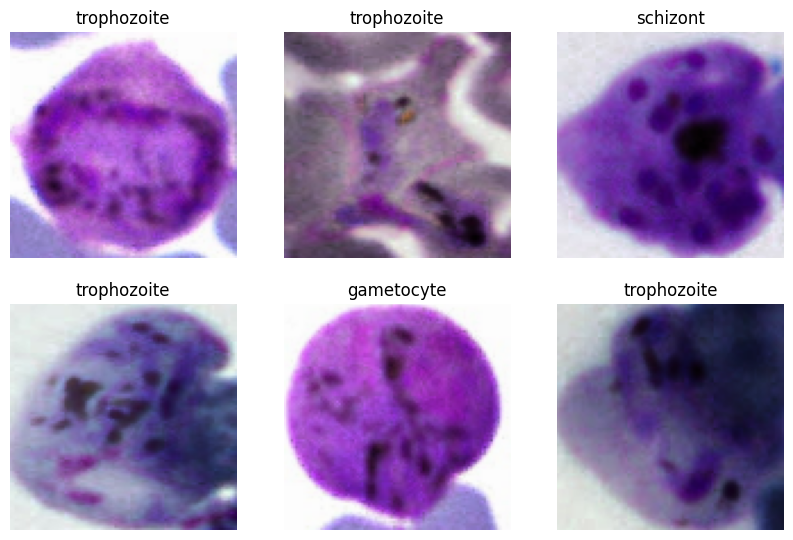

In [14]:
plt.figure(figsize=(10, 10))
for images, labels in train_df.take(1):
  for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [103]:
def set_nontrainable_layers(model):
    model.trainable = False  
    return model
    
def updated_vgg16_model():

    input = layers.Input(shape = (100, 100, 3))
    x = preprocess_input(input)
    
    vgg16model = VGG16(weights="imagenet", include_top=False)
    base_model = set_nontrainable_layers(vgg16model)
    
    x = base_model(x)
    x = layers.Flatten()(x)
    
    x = layers.Dense(100, activation='relu')(x)
    output = layers.Dense(5, activation='softmax')(x)
    
    
    # model = Sequential([base_model, flatten_layer, dense_layer, prediction_layer])
    model = tf.keras.Model(inputs = input, outputs = output)
    
    metrics=['categorical_accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.F1Score(), tf.keras.metrics.AUC()]

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=metrics)

    return model

In [104]:
onehot_train_df = train_df.map(lambda x, y: (x, tf.one_hot(y, depth=5)))
onehot_val_df = val_df.map(lambda x, y: (x, tf.one_hot(y, depth=5)))

In [105]:
no_aug_vgg16_model = updated_vgg16_model()
es=EarlyStopping(patience=3, restore_best_weights=True)
no_aug_vgg16_model.summary()


vgg16_model__noaug_history = no_aug_vgg16_model.fit(onehot_train_df, epochs=100, validation_data=onehot_val_df, callbacks=[es], verbose=1)

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 100, 100, 3)]     0         
                                                                 
 tf.__operators__.getitem_1  (None, 100, 100, 3)       0         
 2 (SlicingOpLambda)                                             
                                                                 
 tf.nn.bias_add_12 (TFOpLam  (None, 100, 100, 3)       0         
 bda)                                                            
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten_12 (Flatten)        (None, 4608)              0         
                                                                 
 dense_24 (Dense)            (None, 100)               460

In [106]:
no_aug_vgg16_model.evaluate(onehot_train_df)

12/12 [==============================] - 2s 164ms/step - loss: 0.3561 - categorical_accuracy: 0.9169 - precision_12: 0.9167 - recall_12: 0.9141 - f1_score: 0.9170 - auc_12: 0.9798


[0.3560730218887329,
 0.9168975353240967,
 0.9166666865348816,
 0.9141274094581604,
 array([0.8518518 , 0.9726027 , 0.96644294, 0.8888889 , 0.9054054 ],
       dtype=float32),
 0.9798421263694763]

In [107]:
no_aug_vgg16_model.evaluate(onehot_val_df)

5/5 [==============================] - 1s 165ms/step - loss: 3.0919 - categorical_accuracy: 0.6039 - precision_12: 0.6067 - recall_12: 0.5909 - f1_score: 0.6120 - auc_12: 0.8167


[3.09187912940979,
 0.6038960814476013,
 0.6066666841506958,
 0.5909090638160706,
 array([0.5681818 , 0.85714287, 0.64406776, 0.5142857 , 0.47619048],
       dtype=float32),
 0.8167378306388855]

In [108]:
onehot_test_df = test_df.map(lambda x, y: (x, tf.one_hot(y, depth=5)))
no_aug_vgg16_model.evaluate(onehot_test_df)

1/1 [==============================] - 0s 167ms/step - loss: 1.4202 - categorical_accuracy: 0.5600 - precision_12: 0.5833 - recall_12: 0.5600 - f1_score: 0.5305 - auc_12: 0.8282


[1.4201823472976685,
 0.5600000023841858,
 0.5833333134651184,
 0.5600000023841858,
 array([0.53333336, 0.5714286 , 0.71428573, 0.5       , 0.3333333 ],
       dtype=float32),
 0.8281999826431274]

In [121]:
no_aug_vgg16_model.get_config()

{'name': 'model_12',
 'trainable': True,
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 100, 100, 3),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'input_25'},
   'name': 'input_25',
   'inbound_nodes': []},
  {'class_name': 'SlicingOpLambda',
   'config': {'name': 'tf.__operators__.getitem_12',
    'trainable': True,
    'dtype': 'float32',
    'function': '__operators__.getitem'},
   'name': 'tf.__operators__.getitem_12',
   'inbound_nodes': [['input_25',
     0,
     0,
     {'slice_spec': (Ellipsis, {'start': None, 'stop': None, 'step': -1})}]]},
  {'class_name': 'TFOpLambda',
   'config': {'name': 'tf.nn.bias_add_12',
    'trainable': True,
    'dtype': 'float32',
    'function': 'nn.bias_add'},
   'name': 'tf.nn.bias_add_12',
   'inbound_nodes': [['tf.__operators__.getitem_12',
     0,
     0,
     {'bias': [-103.93900299072266, -116.77899932861328, -123.68000030517578],
      'data_format': 'NHWC'}]]},
  {'clas

In [135]:
no_aug_vgg16_model.save('Vivax_stages_model.h5', save_format="h5")

In [123]:
no_aug_vgg16_model.save_weights("Vivax_stages_model_weights")

In [137]:
from tensorflow.keras import models

loaded_model = models.load_model("Vivax_stages_model.h5")

In [138]:
loaded_model.evaluate(onehot_val_df)

5/5 [==============================] - 2s 309ms/step - loss: 3.0919 - categorical_accuracy: 0.6039 - precision_12: 0.6067 - recall_12: 0.5909 - f1_score: 0.6120 - auc_12: 0.8167


[3.09187912940979,
 0.6038960814476013,
 0.6066666841506958,
 0.5909090638160706,
 array([0.5681818 , 0.85714287, 0.64406776, 0.5142857 , 0.47619048],
       dtype=float32),
 0.8167378306388855]